<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


# Объявление библиотек

In [1]:
!pip install torch torchmetrics segmentation_models_pytorch

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams

# Загрузка данных

1. Для начала мы скачаем датасет: ADDI project.
2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

In [3]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
get_ipython().system_raw("unrar x PH2Dataset.rar")

zsh:1: command not found: gdown

UNRAR 7.11 freeware      Copyright (c) 1993-2025 Alexander Roshal



Cannot open PH2Dataset.rar
No such file or directory


No files to extract


In [4]:
from skimage.io import imread


images, lesions = [], []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать `skimage.transform.resize()`

Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = np.array([resize(x, size, mode='constant', anti_aliasing=True,) for x in images], np.float32)
Y = np.array([resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions], np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

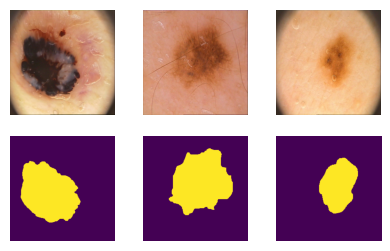

In [6]:
plt.figure(figsize=(10, 3))

for i in range(3):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])

plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
tr, val, ts = np.split(np.random.choice(len(X), len(X), False), [100, 150])
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [8]:
from torch.utils.data import DataLoader


batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)


mps


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [10]:
from torchmetrics import JaccardIndex


iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**


$$\mathcal \sigma(\hat y) = \frac{1}{1+\exp(-\hat y)} \\ 1-\sigma(\hat y) = \frac{\exp(-\hat y)}{1+\exp(-\hat y)} \space$$



\
\begin{aligned}
\mathcal L_{BCE}(y, \hat y)
&= -\sum_i \Biggl[ y_i \log\left(\frac{1}{1+\exp(-\hat y_i)}\right) + (1-y_i) \log\left(\frac{\exp(-\hat y_i)}{1+\exp(-\hat y_i)}\right) \Biggr] =\\
&= -\sum_i \Biggl[ y_i \Bigl(-\log\bigl(1+\exp(-\hat y_i)\bigr)\Bigr) + (1-y_i) \Bigl(-\hat y_i -\log\bigl(1+\exp(-\hat y_i)\bigr)\Bigr) \Biggr] =\\
&= \sum_i \Bigl[ y_i\log\bigl(1+\exp(-\hat y_i)\bigr) + (1-y_i)\hat y_i + (1-y_i)\log\bigl(1+\exp(-\hat y_i)\bigr) \Bigr] =\\
&= \sum_i \Bigl[ (1-y_i)\hat y_i + \bigl(y_i + (1-y_i)\bigr)\log\bigl(1+\exp(-\hat y_i)\bigr) \Bigr] =\\
&= \sum_i \Bigl[(1-y_i)\hat y_i + \log\bigl(1+\exp(-\hat y_i)\bigr)\Bigr] =\\
&= (1-y)\hat y + \log\bigl(1+\exp(-\hat y)\bigr) =\\
&= \hat y - y\hat y + \log\bigl(1+\exp(-\hat y)\bigr)
\end{aligned}



### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [11]:
bce_torch = nn.BCELoss(reduction='mean')
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='mean')

In [12]:
def bce_loss(y_pred, y_true):
    max_val = torch.clamp(y_pred, min=0)
    loss = max_val - y_pred * y_true + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    return loss.mean()

def bce_true(y_pred, y_true):
    eps = 1e-8
    pred_sigmoid = torch.sigmoid(y_pred)
    loss = -(y_true * torch.log(pred_sigmoid + eps) + (1 - y_true) * torch.log(1 - pred_sigmoid + eps))
    return loss.mean()

Проверим корректность работы на простом примере

In [13]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss =            {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный =               {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch =             {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')

BCE loss from scratch bce_loss =            0.829460620880127
BCE loss честно посчитанный =               0.8294606804847717
BCE loss from torch bce_torch =             0.8294606804847717
BCE loss from torch with logits bce_torch = 0.8294607996940613


In [14]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [15]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss =             {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный =                {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch =              {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch =  {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss =             0.8789030313491821
BCE loss честно посчитанный =                0.8789030313491821
BCE loss from torch bce_torch =              0.8789030313491821
BCE loss from torch with logits bce_torch =  0.8789030313491821


In [16]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [17]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

zsh:1: command not found: gdown


In [18]:
path_to_dummy_samples = 'for_asserts'

dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

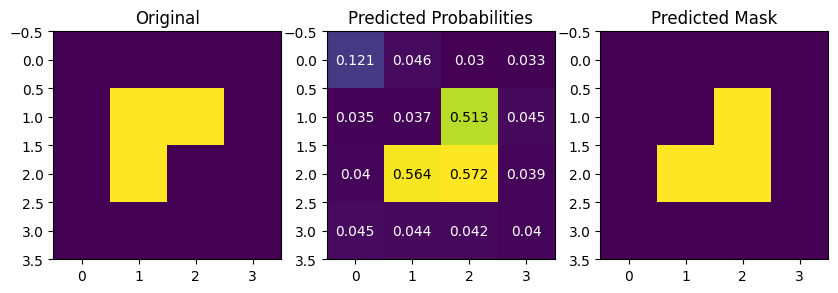

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [20]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

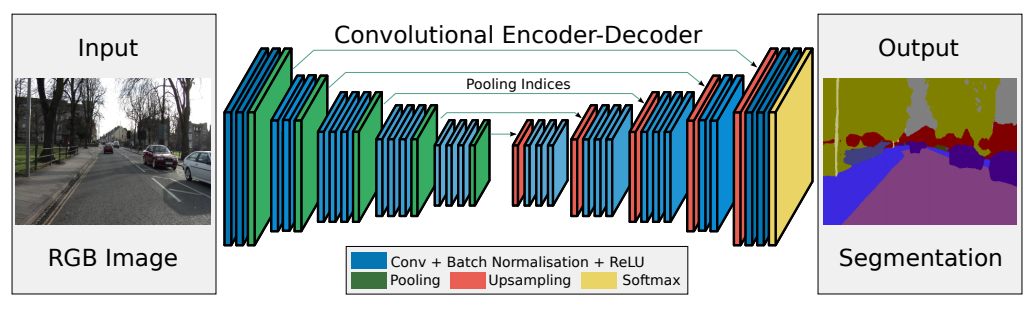

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [21]:
device = torch.device('mps')

In [22]:
import torch
import torch.nn as nn

class CustomMaxUnpool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, input, indices, output_size):
        # Переносим вход и индексы на CPU для выполнения операции
        input_cpu = input.cpu()
        indices_cpu = indices.cpu()
        # Выполняем max_unpool2d на CPU
        out_cpu = F.max_unpool2d(input_cpu, indices_cpu,
                                 kernel_size=self.kernel_size,
                                 stride=self.stride,
                                 padding=self.padding,
                                 output_size=output_size)
        # Переносим результат обратно на исходное устройство
        return out_cpu.to(input.device)


In [23]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SegNet, self).__init__()

        self.enc1_conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.enc1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc2_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # ---- Bottleneck ----
        self.bottleneck_conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.reduce = nn.Conv2d(256, 128, kernel_size=1)

        # ---- Decoder ----
        self.unpool2 = CustomMaxUnpool2d(kernel_size=2, stride=2)
        #self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec2_conv1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dec2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.reduce2 = nn.Conv2d(128, 64, kernel_size=1)

        self.unpool1 = CustomMaxUnpool2d(kernel_size=2, stride=2)
        #self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec1_conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # ---- Encoder ----
        x = self.relu(self.enc1_conv1(x))
        x = self.relu(self.enc1_conv2(x))
        size1 = x.size()
        x, indices1 = self.pool1(x)

        x = self.relu(self.enc2_conv1(x))
        x = self.relu(self.enc2_conv2(x))
        size2 = x.size()
        x, indices2 = self.pool2(x)

        # ---- Bottleneck ----
        x = self.relu(self.bottleneck_conv1(x))
        x = self.relu(self.bottleneck_conv2(x))
        x = self.reduce(x)

        # ---- Decoder ----
        x = self.unpool2(x, indices2, output_size=size2)
        x = self.relu(self.dec2_conv1(x))
        x = self.relu(self.dec2_conv2(x))
        x = self.reduce2(x)

        x = self.unpool1(x, indices1, output_size=size1)
        x = self.relu(self.dec1_conv1(x))
        x = self.relu(self.dec1_conv2(x))

        output = self.out_conv(x)
        return output


## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [24]:
from tqdm.notebook import tqdm

In [25]:
def train(model, device, train_loader, val_loader, criterion, optimizer, num_epochs):
    """
    Функция для обучения модели сегментации.

    Параметры:
      model       - обучаемая модель
      device      - устройство
      train_loader- DataLoader для тренировочного набора.
      val_loader  - DataLoader для валидационного набора
      criterion   - функция потерь (loss)
      optimizer   - оптимизатор
      num_epochs  - число эпох обучения.
    """
    model.to(device)
    losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    inputs, targets = batch
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)

            val_epoch_loss = val_loss / len(val_loader.dataset)

        print(f"Epoch {epoch+1:2d}/{num_epochs} - Train loss: {epoch_loss:.4f} - Val loss: {val_epoch_loss:.4f}")
        losses.append(val_epoch_loss)

    return model, losses

Обучите модель **SegNet**.

In [26]:
segnet_model = SegNet()
criterion = bce_true
optimizer = optim.Adam(segnet_model.parameters(), lr=1e-4)
num_epochs = 12
trained_model = train(segnet_model, device, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs)

Epoch  1/12 - Train loss: 0.6811 - Val loss: 0.6763
Epoch  2/12 - Train loss: 0.6800 - Val loss: 0.6748
Epoch  3/12 - Train loss: 0.6789 - Val loss: 0.6731
Epoch  4/12 - Train loss: 0.6775 - Val loss: 0.6708
Epoch  5/12 - Train loss: 0.6751 - Val loss: 0.6655
Epoch  6/12 - Train loss: 0.6682 - Val loss: 0.6468
Epoch  7/12 - Train loss: 0.6418 - Val loss: 0.5827
Epoch  8/12 - Train loss: 0.6065 - Val loss: 0.5528
Epoch  9/12 - Train loss: 0.5934 - Val loss: 0.5549
Epoch 10/12 - Train loss: 0.5867 - Val loss: 0.5475
Epoch 11/12 - Train loss: 0.5724 - Val loss: 0.5151
Epoch 12/12 - Train loss: 0.5499 - Val loss: 0.4963


## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [27]:
def test(model, device, test_loader, criterion, checkpoint_path=None):
    """
    Функция для тестирования модели сегментации.

    Параметры:
      model           - обучаемая модель (например, SegNet).
      device          - устройство выполнения (cpu или cuda).
      test_loader     - DataLoader для тестовой выборки.
      criterion       - функция потерь (например, BCEWithLogitsLoss).
      checkpoint_path - путь к файлу с лучшим чекпоинтом модели (если указан, модель загружается из чекпоинта).
    """
    if checkpoint_path is not None:
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"Чекпоинт загружен: {checkpoint_path}")

    model.to(device)
    model.eval()
    test_loss = 0.0
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            targets = torch.tensor(targets, dtype=torch.float32).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

    test_loss = test_loss / len(test_loader.dataset)
    print(f"Test loss: {test_loss:.4f}")

    return model

In [28]:
trained_model = test(segnet_model, device, test_dataloader, criterion)

/var/folders/92/02lmmcn14v70tskxl025nk5h0000gn/T/ipykernel_1037/2935208353.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
/var/folders/92/02lmmcn14v70tskxl025nk5h0000gn/T/ipykernel_1037/2935208353.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32).to(device)


Test loss: 0.5120


# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [29]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):

    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    labels = labels.float()

    intersection = (preds * labels).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + labels.sum(dim=(1, 2, 3))
    score = (2 * intersection + 1e-7) / (union + 1e-7)

    return score.mean().item()


Проверим на корректность функцию dice_score:

In [30]:
from torchmetrics.segmentation import DiceScore


dice = DiceScore(num_classes=1).to(device)
dice((dummpy_sample['logits'].sigmoid() > 0.5).int(), dummpy_sample['labels'].int())

tensor(0.6667, device='mps:0')

In [31]:
assert dice((dummpy_sample['logits'].sigmoid() > 0.5).int(), dummpy_sample['labels'].int()) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [32]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    probs = torch.sigmoid(logits)
    intersection = (probs * labels).sum(dim=(1, 2, 3))
    union = probs.sum(dim=(1, 2, 3)) + labels.sum(dim=(1, 2, 3))

    dice = (2 * intersection + 1e-7) / (union + 1e-7)
    loss = 1 - dice.mean()
    return loss


Проверка на корректность:

In [33]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

/Users/mr1necs/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor(0.5756, device='mps:0')

In [34]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels']) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [35]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    p = torch.sigmoid(y_pred)
    p = torch.clamp(p, eps, 1 - eps)

    loss_pos = - (1 - p)**gamma * y_real * torch.log(p)
    loss_neg = - p**gamma * (1 - y_real) * torch.log(1 - p)

    loss = loss_pos + loss_neg
    return loss.mean()

Проверка корректности функции:

In [36]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='mean')

tensor(0.2260, device='mps:0')

In [37]:
assert str(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='mean')) == str(focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0))

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [38]:
from scipy.ndimage import binary_erosion, distance_transform_edt

def boundary_loss(logits: torch.Tensor, labels: torch.Tensor, eps=1e-8):
    """
    Вычисляет Boundary Loss для сильно несбалансированной сегментации.

    Формула (в упрощённом виде):
      L_boundary = sum_{i in Ω} p(i)*d(i) / (sum_{i in Ω} p(i) + eps)
    где:
      - p(i) – предсказанная вероятность для пикселя i (после сигмоиды),
      - d(i) – расстояние от пикселя i до ближайшей границы истинной маски,
      - Ω – все пиксели изображения.

    Аргументы:
      logits - сырые выходы модели (логиты), размер [N, C, H, W] (для бинарной сегментации C=1).
      labels - истинные бинарные маски, размер [N, C, H, W], значения 0 или 1.
      eps    - маленькая константа для предотвращения деления на 0.

    Возвращает:
      loss   - усреднённое значение Boundary loss по батчу.
    """
    probs = torch.sigmoid(logits)
    N = logits.shape[0]
    loss_batch = 0.0

    for i in range(N):
        label_np = labels[i, 0].cpu().numpy().astype(np.uint8)

        eroded = binary_erosion(label_np, structure=np.ones((3, 3)), border_value=0)
        boundary = label_np ^ eroded  # XOR: граница там, где разница

        if boundary.sum() == 0:
            dist_map = np.zeros_like(label_np, dtype=np.float32)
        else:
            dist_map = distance_transform_edt(~boundary.astype(bool)).astype(np.float32)

        dist_map_tensor = torch.from_numpy(dist_map).to(logits.device).float()
        prob = probs[i, 0]
        loss_sample = (prob * dist_map_tensor).sum() / (prob.sum() + eps)
        loss_batch += loss_sample

    return loss_batch.mean()

In [39]:
print(f"BCE loss:      {bce_true(dummpy_sample['labels'], dummpy_sample['logits'])}")
print(f"Dice loss:     {dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])}")
print(f"Focal loss:    {focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2.0)}")
print(f"Boundary loss: {boundary_loss(dummpy_sample['logits'], dummpy_sample['labels'])}")

BCE loss:      0.9944552183151245
Dice loss:     0.5755997896194458
Focal loss:    0.39807456731796265
Boundary loss: 0.5781248807907104


## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [40]:
loss_functions = {
    'BCE': bce_loss,
    'Dice': dice_loss,
    'Focal': focal_loss
}

segnet_results = {}
num_epochs = 10

for loss_name, loss_fn in loss_functions.items():
    print(f"\n=== Training with {loss_name} loss ===")


    model = SegNet()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    trained_model, losses = train(model, device, train_dataloader, valid_dataloader, loss_fn, optimizer, num_epochs)
    segnet_results[loss_name] = losses


=== Training with BCE loss ===
Epoch  1/10 - Train loss: 0.7026 - Val loss: 0.7041
Epoch  2/10 - Train loss: 0.7011 - Val loss: 0.7020
Epoch  3/10 - Train loss: 0.6993 - Val loss: 0.6998
Epoch  4/10 - Train loss: 0.6973 - Val loss: 0.6966
Epoch  5/10 - Train loss: 0.6941 - Val loss: 0.6903
Epoch  6/10 - Train loss: 0.6862 - Val loss: 0.6700
Epoch  7/10 - Train loss: 0.6554 - Val loss: 0.6016
Epoch  8/10 - Train loss: 0.6147 - Val loss: 0.5568
Epoch  9/10 - Train loss: 0.6033 - Val loss: 0.5539
Epoch 10/10 - Train loss: 0.5874 - Val loss: 0.5547

=== Training with Dice loss ===
Epoch  1/10 - Train loss: 0.6334 - Val loss: 0.6665
Epoch  2/10 - Train loss: 0.6324 - Val loss: 0.6657
Epoch  3/10 - Train loss: 0.6314 - Val loss: 0.6648
Epoch  4/10 - Train loss: 0.6303 - Val loss: 0.6639
Epoch  5/10 - Train loss: 0.6290 - Val loss: 0.6627
Epoch  6/10 - Train loss: 0.6274 - Val loss: 0.6607
Epoch  7/10 - Train loss: 0.6238 - Val loss: 0.6561
Epoch  8/10 - Train loss: 0.6152 - Val loss: 0.6417

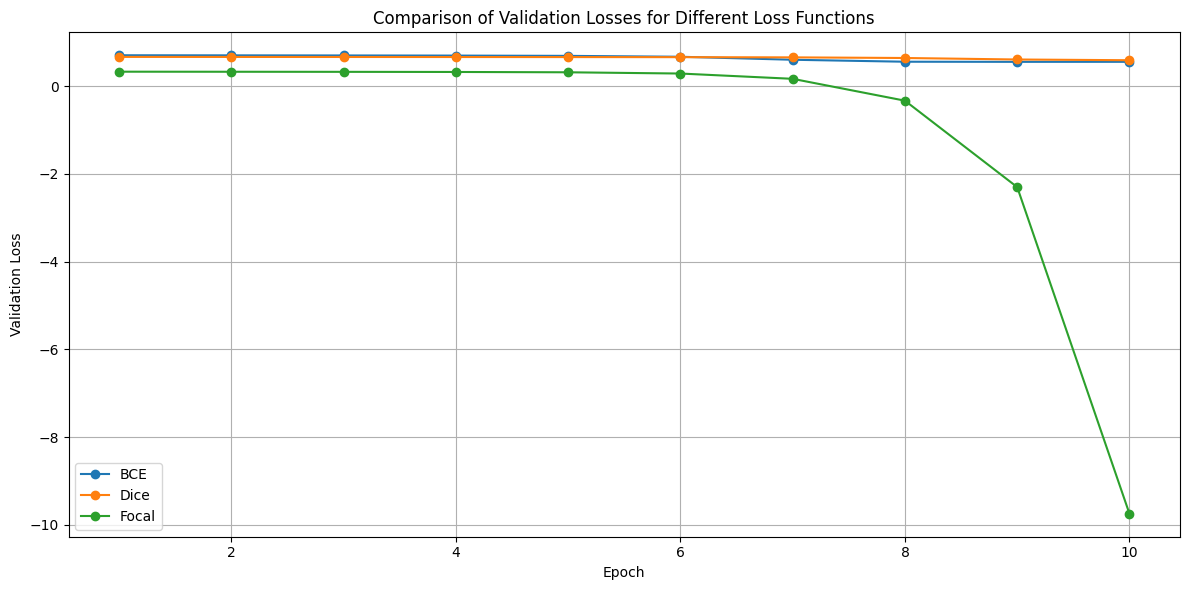

In [41]:
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
for loss_name, losses in segnet_results.items():
    plt.plot(epochs, losses, marker='o', label=loss_name)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Comparison of Validation Losses for Different Loss Functions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Анализ сходимости

Сходимость по скорости:

BCE loss:
Значения лосса меняются постепенно от ~0.70 до ~0.59 на обучающей и от ~0.70 до ~0.55 на валидационной выборках. Сходимость происходит плавно, и модель продолжает улучшаться в течение всех 10 эпох.

Dice loss:
Здесь значения потерь практически не меняются в первые 5–6 эпох (около 0.63–0.62), а затем наблюдается постепенное снижение до ~0.55 (тренировочный) и до ~0.59 (валидационный). По динамике улучшения сходимость у Dice loss выглядит несколько более стабильной и медленной.

Focal loss:
Уже на первых 5 эпохах показатели значительно ниже (тренировочный лосс около 0.35 и валидационный около 0.32). Однако начиная с 7-й эпохи наблюдается резкое снижение, и значения лосса становятся даже отрицательными (например, к 10-й эпохе –4.72 для обучения и –9.74 для валидации). Это говорит о том, что по числовой динамике модель, обученная с Focal loss, сходится быстрее.


Интерпретация отрицательных значений Focal loss:

Отрицательные значения могут возникать, если параметры фокальной функции (например, alpha) заданы не по стандарту или если сеть выдает чрезвычайно уверенные предсказания, что приводит к очень большим (отрицательным) значениям логарифмов. Такие негативные значения могут указывать на численную нестабильность или переобучение, поэтому важно дополнительно проверить качество сегментации с помощью вычисления метрики (например, Dice score) на тестовой выборке.


Итоговые наблюдения

Сходимость модели:

По логам видно, что модель, обученная с Focal loss, сходится быстрее – уже к 7-й эпохе наблюдается резкое снижение лосса, а к 8-й и последующим эпохам значения становятся очень низкими или отрицательными. Однако это может быть признаком численной нестабильности.

Лучшая метрика:

Для окончательного выбора лучшей функции потерь нужно дополнительно сравнить итоговые метрики качества сегментации (например, Dice score, IoU и т.д.) на валидационном/тестовом наборах. Если модель, обученная с Dice loss, показывает наивысшую Dice score, то её можно считать оптимальной, даже если Focal loss по скорости сходимости показывает резкий спад.

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

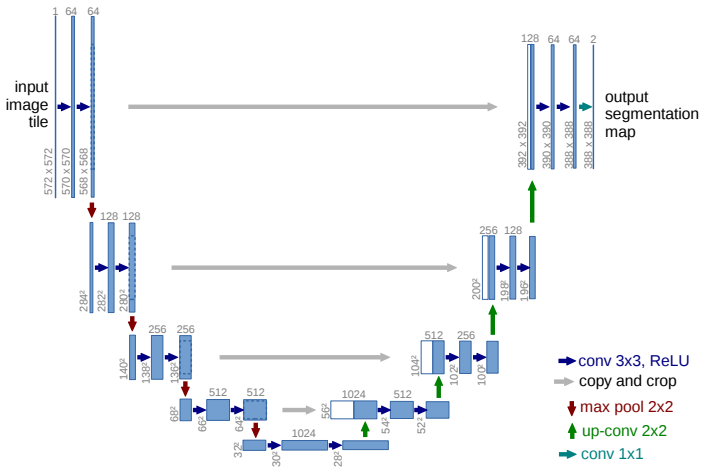

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [42]:
import torch.nn.functional as F
import torch.nn as nn

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, n_class=1):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.center = self.conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)  # после конкатенации с enc4

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)   # после конкатенации с enc3

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)   # после конкатенации с enc2

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)    # после конкатенации с enc1

        self.out_conv = nn.Conv2d(64, n_class, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Стандартный блок из двух свёрточных слоёв с активацией ReLU"""
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        center = self.center(p4)
        d4 = self.up4(center)

        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        output = self.out_conv(d1)
        return output

In [44]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [45]:
loss_functions = {
    'BCE': bce_loss,
    'Dice': dice_loss,
    'Focal': focal_loss
}

unet_results = {}
num_epochs = 10

for loss_name, loss_fn in loss_functions.items():
    print(f"\n=== Training with {loss_name} loss ===")
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    trained_model, losses = train(model, device, train_dataloader, valid_dataloader, loss_fn, optimizer, num_epochs)
    unet_results[loss_name] = losses


=== Training with BCE loss ===
Epoch  1/10 - Train loss: 0.6988 - Val loss: 0.6934
Epoch  2/10 - Train loss: 0.6882 - Val loss: 0.6797
Epoch  3/10 - Train loss: 0.6760 - Val loss: 0.6597
Epoch  4/10 - Train loss: 0.6573 - Val loss: 0.6291
Epoch  5/10 - Train loss: 0.6298 - Val loss: 0.5758
Epoch  6/10 - Train loss: 0.6239 - Val loss: 0.5580
Epoch  7/10 - Train loss: 0.6001 - Val loss: 0.5653
Epoch  8/10 - Train loss: 0.5952 - Val loss: 0.5616
Epoch  9/10 - Train loss: 0.5904 - Val loss: 0.5527
Epoch 10/10 - Train loss: 0.5863 - Val loss: 0.5429

=== Training with Dice loss ===
Epoch  1/10 - Train loss: 0.6317 - Val loss: 0.6645
Epoch  2/10 - Train loss: 0.6295 - Val loss: 0.6626
Epoch  3/10 - Train loss: 0.6271 - Val loss: 0.6602
Epoch  4/10 - Train loss: 0.6235 - Val loss: 0.6565
Epoch  5/10 - Train loss: 0.6181 - Val loss: 0.6497
Epoch  6/10 - Train loss: 0.6056 - Val loss: 0.6306
Epoch  7/10 - Train loss: 0.5654 - Val loss: 0.5907
Epoch  8/10 - Train loss: 0.5404 - Val loss: 0.5918

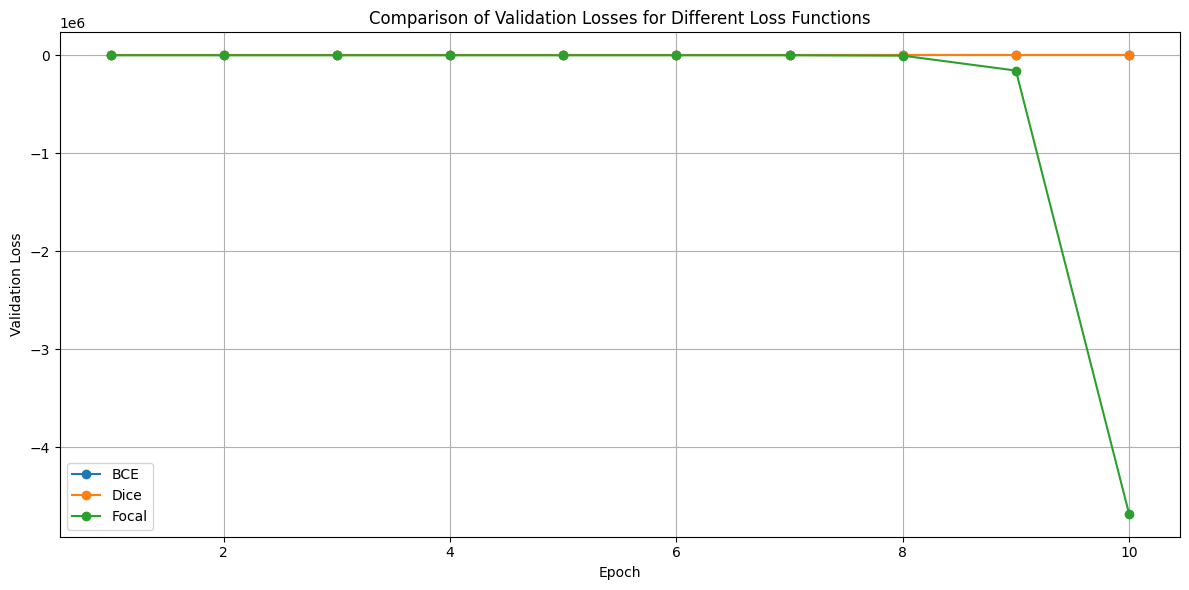

In [46]:
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
for loss_name, losses in unet_results.items():
    plt.plot(epochs, losses, marker='o', label=loss_name)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Comparison of Validation Losses for Different Loss Functions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

UNet с BCE loss:

Логи показывают плавное снижение значений лосса – от примерно 0.70 на первой эпохе до 0.586 (train) и 0.543 (validation) на десятой эпохе.
Такое снижение демонстрирует стабильную и предсказуемую сходимость.
UNet с Dice loss:

Значения лосса начинают от ~0.632 и к 10-й эпохе снижаются до примерно 0.541–0.591. Здесь динамика улучшения выглядит стабильной, но скорость сходимости немного ниже, чем при использовании BCE loss (слегка более пологая кривая на первых эпохах).
UNet с Focal loss:

Первые несколько эпох показывают относительно низкие значения (около 0.32–0.35), что свидетельствует о быстрой первичной сходимости.
Однако начиная с 6-й эпохи происходит резкое падение значений (train loss становится 0.028, затем отрицательное, и к 10-й эпохе зафиксированы очень отрицательные числа). Отрицательные значения указывают на числовую нестабильность – вероятно, из-за слишком агрессивного подавления «легких» примеров или несоответствия параметров focal loss (например, установка alpha или gamma в неподходящие значения).
Сравнение с SegNet:
Из ранее приведённых логов обучения SegNet с теми же потерями видно, что:

При BCE loss SegNet снижал валид. лосс с 0.7041 до 0.5547, при Dice loss – с 0.6665 до 0.5909, а при Focal loss также наблюдались резкие изменения с отрицательными значениями.
В сравнении с SegNet, UNet с BCE loss достигает немного более низких валид. потерь (0.5429 против 0.5547) и, вероятно, сходится быстрее благодаря наличию skip-коннекций, позволяющих лучше сохранять пространственную информацию.